In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
import tensorflow as tf
from hazardGAN import utils, fig_utils
from scipy.stats import ecdf
from scipy.stats import genextreme, genpareto, uniform
from importlib import reload
reload(utils)

plt.rcParams["font.family"] = "monospace"

# get indices from ravel indices
def translate_indices(i, dims=(18, 22)):
    indices = np.arange(0, dims[0] * dims[1], 1)
    x = np.argwhere(indices.reshape(dims[0], dims[1]) == i)
    return tuple(*map(tuple, x))

def translate_indices_r(i, j, dims=(18, 22)):
    indices = np.arange(0, dims[0] * dims[1], 1)
    x = indices.reshape(dims[0], dims[1])[i, j]
    return x


ntrain = 2000
conditions = "all"
dim_dict = {'wind_data': 'total', 'wave_data': 'swh', 'precip_data': 'tp'}
hist_kwargs = {'color': 'lightgrey', 'alpha': .6, 'edgecolor': 'k', 'density': True}

variable = 'wave_data'
block_size = "weekly"
dim = dim_dict[variable]

datadir = f"/Users/alison/Documents/DPhil/multivariate/{variable}"
figdir = "/Users/alison/Documents/DPhil/multivariate/hazardGAN/figures"

# Generate the train/test sets (optional save)

In [8]:
reload(utils)
# test pixel for plotting
ij = 294
i, j = translate_indices(ij)

In [9]:
# load data
data, cyclone_flag = utils.load_data(datadir, dim=dim, block_size=block_size)
train = data[:ntrain, ...]
test = data[ntrain:, ...]
x_valid, y_valid = np.where(np.std(train, axis=(0, 3)) > 0 ) # note coords with nonzero std
indices_valid = [translate_indices_r(i, j) for i, j in zip(x_valid, y_valid)]

# make dirs if they don't exist
if not os.path.exists(os.path.join(datadir, block_size, 'test')):
    os.makedirs(os.path.join(datadir, block_size, 'test'))
    
if not os.path.exists(os.path.join(datadir, block_size, 'train')):
    os.makedirs(os.path.join(datadir, block_size, 'train'))

np.save(os.path.join(datadir, block_size, 'test', 'images.npy'), test) 
np.save(os.path.join(datadir, block_size, 'train', 'images.npy'), train)

u_x (13, 8): 14.3101


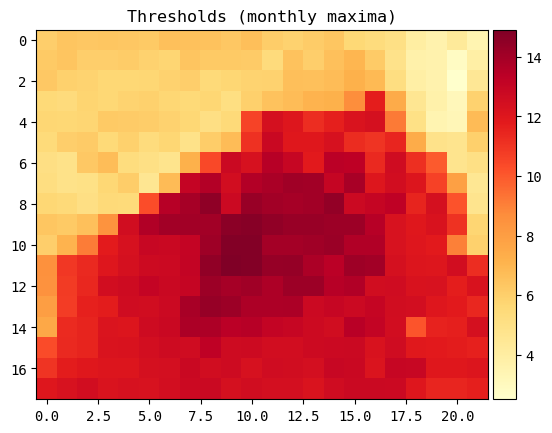

In [142]:
# after calculating thresholds
thresholds = np.load(os.path.join(datadir, block_size, 'train', 'pot', 'thresholds.npy'))
print(f'u_x ({i}, {j}): {thresholds[i, j]:.4f}')

fig, ax = plt.subplots()
im = ax.imshow(thresholds, cmap="YlOrRd")
ax.set_title('Thresholds ({} maxima)'.format(block_size));
fig_utils.add_colorbar(fig, im, ax)

In [143]:
# fit a GEV to all data
if False:
    reload(utils)
    save = True

    # test first
    marginals, params = utils.probability_integral_transform(test[:3, ...], evt_type='block-maxima')
    if save:
        np.save(os.path.join(datadir, block_size, 'test', 'bm', 'marginals.npy'), marginals)
        np.save(os.path.join(datadir, block_size, 'test', 'bm', 'images.npy'), test)
        np.save(os.path.join(datadir, block_size, 'test', 'bm', 'params.npy'), params)


    # train set
    marginals, params = utils.probability_integral_transform(train[:2, ...], evt_type='block-maxima')
    if save:
        np.save(os.path.join(datadir, block_size, 'train', 'bm', 'marginals.npy'), marginals)
        np.save(os.path.join(datadir, block_size, 'train', 'bm', 'images.npy'), train)
        np.save(os.path.join(datadir, block_size, 'train', 'bm', 'params.npy'), params)


    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].hist(params[x_valid, y_valid, 0].ravel(), bins=50, **hist_kwargs);
    axs[1].hist(train[:, x_valid, y_valid, 0].ravel(), bins=50, **hist_kwargs);    

In [144]:
# transform and create train/test sets
reload(utils)
r = None
save = False

# test first
marginals, params = utils.probability_integral_transform(test, prior=None, thresholds=thresholds, fit_tail=True, decluster=r)
if save:
    np.save(os.path.join(datadir, block_size, 'test', 'pot', 'marginals.npy'), marginals)
    np.save(os.path.join(datadir, block_size, 'test', 'pot', 'images.npy'), test)
    np.save(os.path.join(datadir, block_size, 'test', 'pot', 'params.npy'), params)
    
    
# train set
marginals, params = utils.probability_integral_transform(train, thresholds=thresholds, fit_tail=True, decluster=r)
if save:
    np.save(os.path.join(datadir, block_size, 'train', 'pot', 'marginals.npy'), marginals)
    np.save(os.path.join(datadir, block_size, 'train', 'pot', 'images.npy'), train)
    np.save(os.path.join(datadir, block_size, 'train', 'pot', 'params.npy'), params)
    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].hist(params[x_valid, y_valid, 0].ravel(), bins=50, **hist_kwargs);
axs[1].hist(train[:, x_valid, y_valid, 0].ravel(), bins=50, **hist_kwargs);    

ValueError: zero-size array to reduction operation maximum which has no identity

## Autocorrelation and declustering
Check data for dependence and choose a suitable $r$ for declustering.

Original process shows both heteroskedasticity and seasonality. Might suit a GARCH model.


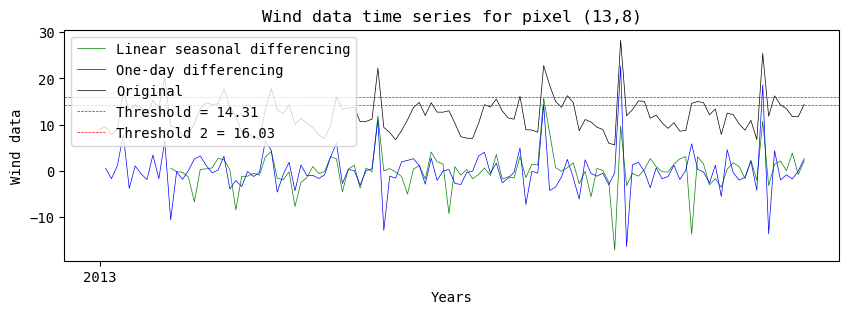

In [145]:
# stationarity test
n, h, w, c = train.shape

x = range(n)
y = train[:, i, j, 0]
thresh = thresholds[i, j]
thresh_2 = np.quantile(y, 0.9)

fig, axs = plt.subplots(figsize=(10, 3))
axs.plot(x[12:], utils.diff(y, 12), color='green', linewidth=.5, label='Linear seasonal differencing')
axs.plot(x[1:], utils.diff(y), color='blue', linewidth=.5, label='One-day differencing')
axs.plot(x, y, '-k', linewidth=.5, label='Original')
axs.axhline(thresh, color='red', linestyle='--', linewidth=.5, label=f'Threshold = {thresh:.2f}')
axs.axhline(thresh_2, color='red', linestyle='--', linewidth=.5, label=f'Threshold 2 = {thresh_2:.2f}')

axs.legend()

# add labels
years = np.arange(0, n, 365)
nyears = len(years)
yearnames = [2013 + i for i in range(nyears)]
axs.set_xticks(years, labels=yearnames);
axs.set_xlabel('Years');
axs.set_ylabel(variable.replace('_', ' ').capitalize());
axs.set_title('{} time series for pixel ({},{})'.format(variable.replace('_', ' ').capitalize(),i,j))
fig.savefig(os.path.join(figdir, 'general', f'example_time_series_{block_size}.png'), dpi=300, bbox_inches='tight')


print('Original process shows both heteroskedasticity and seasonality. Might suit a GARCH model.')

/Users/alison/Documents/DPhil/multivariate/hazardGAN/hazardGAN/utils.py:180: UserWarning: decluster_array only returns indices of exceedences for r=None.
  warnings.warn(f'decluster_array only returns indices of exceedences for r={r}.')


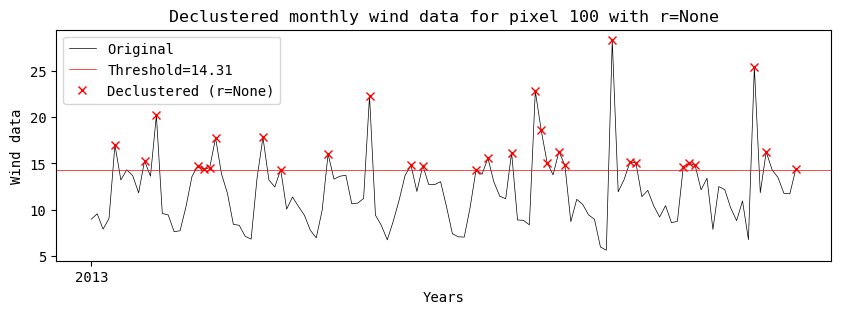

In [146]:
# have  a look at declustering
r = None
reload(utils)
idx_declust = utils.decluster_array(y, thresh, r) 
y_declust = y[idx_declust]

ij = 100
i, j = translate_indices(ij)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(range(n), y, color='k', linewidth=.5, label='Original')
ax.axhline(thresh, color='red', linewidth=.5, label=f"Threshold={thresh:.2f}")
ax.plot(idx_declust, y_declust, 'xr', label='Declustered (r={})'.format(r))
ax.legend()

# pretty stuff
ax.set_xticks(years, labels=yearnames);
ax.set_xlabel('Years');
ax.set_ylabel(variable.replace('_', ' ').capitalize());
ax.set_title('Declustered {} {} for pixel {} with r={}'.format(block_size, variable.replace('_', ' '), ij, r));

fig.savefig(os.path.join(figdir, "general", f"declustered_timeseries_{variable}_{block_size}.png"), dpi=300, bbox_inches='tight')

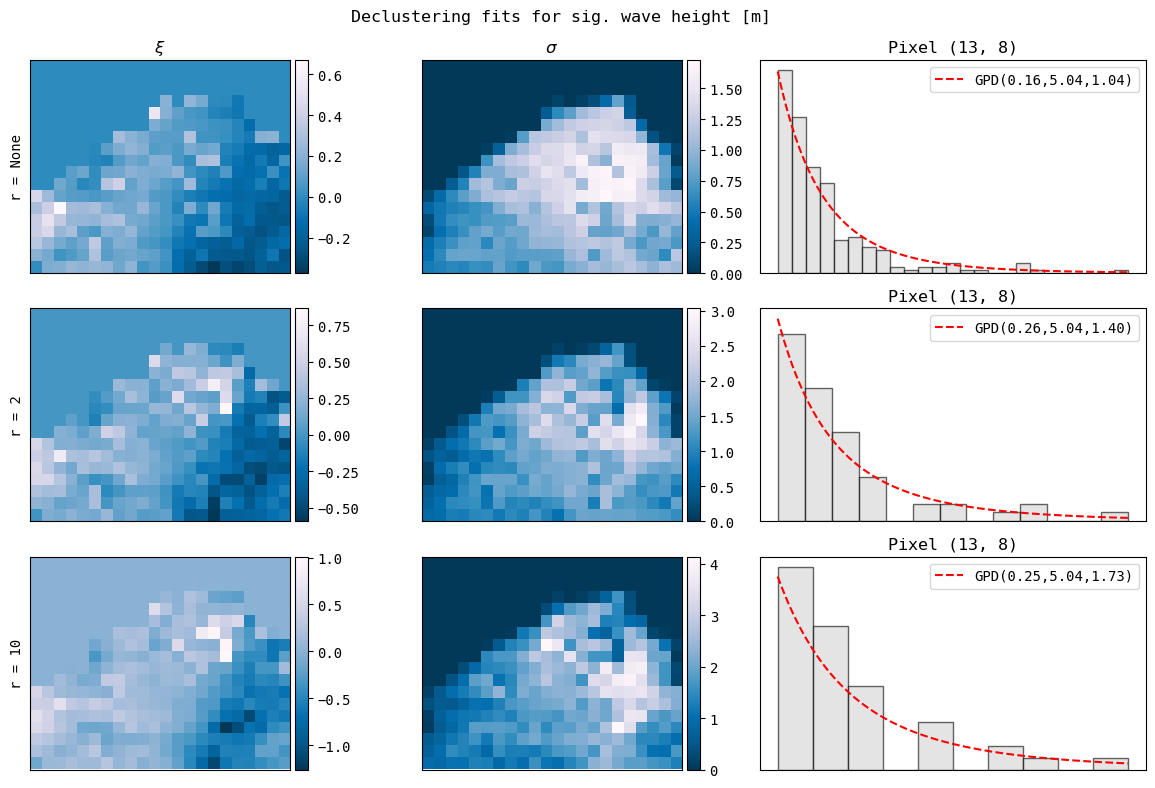

In [444]:
# comparing decluster results
reload(utils)
from scipy.stats import genpareto
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
    
def add_colorbar(fig, ax, im, side='right', size='5%', pad=0.05, orientation='vertical'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(side, size=size, pad=pad)
    fig.colorbar(im, cax=cax, orientation=orientation)
    

fig, axs = plt.subplots(3, 3, figsize=(12, 8), layout='tight')

r = None
_, params = utils.probability_integral_transform(test, evt_type=evt_type, prior=None, thresholds=thresholds, fit_tail=True, decluster=r)
ax = axs[0, :]
for m, param in enumerate([0, 2]):
    im = ax[m].imshow(params[..., param], cmap="PuBu_r")
    add_colorbar(fig, ax[m], im)
ax[0].set_title(r'$\xi$');
ax[1].set_title(r'$\sigma$');
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].set_ylabel(f"r = {r}");

# add plot of fit for sample pixel
params_r = params[i, j]
idx_declust = utils.decluster_array(y, thresh, r)
y_declust = y[idx_declust]
x = np.linspace(min(y_declust), max(y_declust), 100)
ax[2].hist(y_declust, bins='auto', **hist_kwargs);
ax[2].plot(x, genpareto.pdf(x, *params_r), '--r', label='GPD({:.2f},{:.2f},{:.2f})'.format(*params_r))
ax[2].set_title("Pixel ({}, {})".format(i, j))
ax[2].legend()

r = 2
_, params = utils.probability_integral_transform(test, evt_type=evt_type, prior=None, thresholds=thresholds, fit_tail=True, decluster=r)
ax = axs[1, :]
for m, param in enumerate([0, 2]):
    im = ax[m].imshow(params[..., param], cmap="PuBu_r")
    add_colorbar(fig, ax[m], im)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].set_ylabel(f"r = {r}");
# add plot of fit for sample pixel
params_r = params[i, j]
idx_declust = utils.decluster_array(y, thresh, r)
y_declust = y[idx_declust]
x = np.linspace(min(y_declust), max(y_declust), 100)
ax[2].hist(y_declust, bins='auto', **hist_kwargs);
ax[2].plot(x, genpareto.pdf(x, *params_r), '--r', label='GPD({:.2f},{:.2f},{:.2f})'.format(*params_r))
ax[2].set_title("Pixel ({}, {})".format(i, j))
ax[2].legend()
    

r = 10
_, params = utils.probability_integral_transform(test, evt_type=evt_type, prior=None, thresholds=thresholds, fit_tail=True, decluster=r)
ax = axs[2, :]
for m, param in enumerate([0, 2]):
    im = ax[m].imshow(params[..., param], cmap="PuBu_r")
    add_colorbar(fig, ax[m], im)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].set_ylabel(f"r = {r}");

# add plot of fit for sample pixel
params_r = params[i, j]
idx_declust = utils.decluster_array(y, thresh, r)
y_declust = y[idx_declust]
x = np.linspace(min(y_declust), max(y_declust), 100)
ax[2].hist(y_declust, bins='auto', **hist_kwargs);
ax[2].plot(x, genpareto.pdf(x, *params_r), '--r', label='GPD({:.2f},{:.2f},{:.2f})'.format(*params_r))
ax[2].set_title("Pixel ({}, {})".format(i, j))
ax[2].legend();

fig.suptitle(f'Declustering fits for {viz_utils.variable_labels[variable]}')
fig.savefig(os.path.join(figdir, "general", f"declustering_{variable}.png"), dpi=300, bbox_inches='tight')

# Examine results

In [509]:
# compare to nonparametric transform
reload(utils)
r = None
data = test.copy()

# training data
marginals_train, params = utils.probability_integral_transform(train, evt_type=evt_type, thresholds=thresholds, fit_tail=True, decluster=r)
marginals_nonpara_train, *_ = utils.probability_integral_transform(train, thresholds=None, fit_tail=False)

# data of interest
marginals, _ = utils.probability_integral_transform(data, evt_type=evt_type, thresholds=thresholds, fit_tail=True, decluster=r)
marginals_nonpara, *_ = utils.probability_integral_transform(data, thresholds=None, fit_tail=False)
inverse_nonpara = utils.inv_probability_integral_transform(marginals_nonpara, train, marginals_nonpara_train, params=None, thresh=None)
inverse_semipara = utils.inv_probability_integral_transform(marginals, train, marginals_train, params=params[..., np.newaxis], thresh=thresholds)

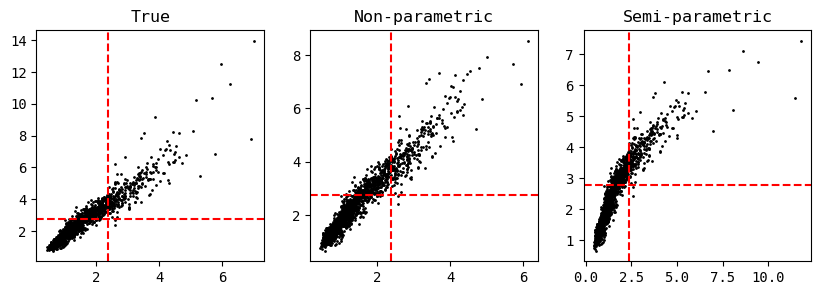

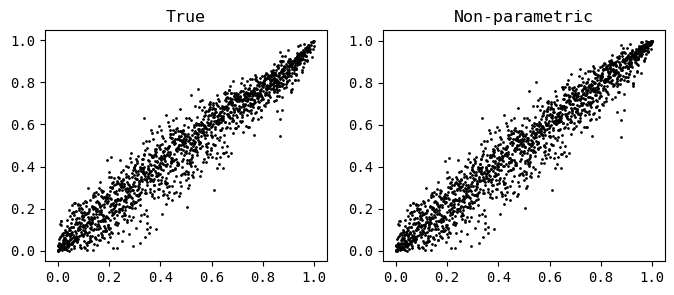

In [510]:
# Plot the scatter plots
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sample_pixels = indices_valid[4], indices_valid[10]

n, h, w, c = data.shape
x0 = data.reshape(n, h * w, c)
x1 = inverse_nonpara.reshape(n, h * w, c)
x2 = inverse_semipara.reshape(n, h * w, c)

ax[0].scatter(x0[:, sample_pixels[0], 0], x0[:, sample_pixels[1], 0], color='k', s=1)
ax[1].scatter(x1[:, sample_pixels[0], 0], x1[:, sample_pixels[1], 0], color='k', s=1)
ax[2].scatter(x2[:, sample_pixels[0], 0], x2[:, sample_pixels[1], 0], color='k', s=1)


for axi in ax:
    axi.axvline(x=thresholds.ravel()[sample_pixels[0]], color='red', linestyle='--')
    axi.axhline(y=thresholds.ravel()[sample_pixels[1]], color='red', linestyle='--')


ax[0].set_title('True')
ax[1].set_title('Non-parametric')
ax[2].set_title('Semi-parametric');



fig, ax = plt.subplots(1, 2, figsize=(8, 3))
m0 = marginals.reshape(n, h * w, c)
m1 = marginals_nonpara.reshape(n, h * w, c)
ax[0].scatter(m0[:, sample_pixels[0], 0], m0[:, sample_pixels[1], 0], color='k', s=1)
ax[1].scatter(m1[:, sample_pixels[0], 0], m1[:, sample_pixels[1], 0], color='k', s=1)
ax[0].set_title('Semiparametric')
ax[1].set_title('Non-parametric');

In [502]:
# goodness of fit test
from scipy.stats import goodness_of_fit

ij = np.random.choice(indices_valid, size=1)[0]
assert ij in indices_valid
i, j = translate_indices(ij)

thresh = thresholds[i, j]
f_thresh = np.interp(thresh, sorted(train[:, i, j, 0]), sorted(marginals[:, i, j, 0]))



test_vec = train[:, i, j, 0].ravel()
# tail_vec = test_vec[test_vec > thresh]
decluster_indices = utils.decluster_array(test_vec, thresh, r)
tail_vec = test_vec[decluster_indices]
shape, loc, scale = params[i, j]

res = goodness_of_fit(genpareto, tail_vec, n_mc_samples=100, statistic='ks',  guessed_params={'c': shape, 'loc': loc, 'scale': scale})

print(f"(shape, loc, scale) = ({shape:.2f}, {loc:.2f}, {scale:.2f})")
print('Kolmogorov-Smirnoff test with H_0: data follows specified distribution')
print(f"Test statistic: {res.statistic:.4f}")
print(f"p-value: {res.pvalue:.4f}")


# plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
res.fit_result.plot(ax=ax[1]);

ax[0].axvline(x=thresh, color='C0', linestyle='--', label='Threshold')
ax[0].hist(train[:, i, j, 0].ravel(), density=True, bins=100, color='C1', label='Histogram of Data');
ax[0].set_xlabel('x')
ax[0].set_ylabel('PDF')
ax[0].legend(loc='upper right')
ax[0].set_title('Histogram');

for a in ax:
    a.label_outer()

    
# plot (i, j) location
fig, ax = plt.subplots(figsize=(2, 2))
ones = np.zeros(train.shape[1:3])
ones[i, j] = 1

ax.imshow(ones, cmap='Reds', label='pixel location')

ValueError: fp and xp are not of the same length.

5.058498859405518


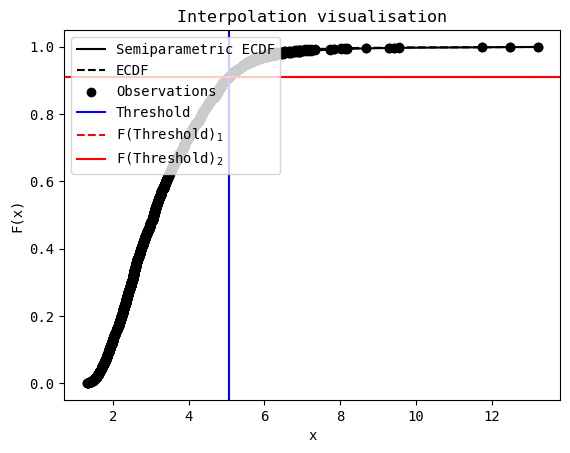

In [466]:
x = train[:, i, j, 0]
y1 = marginals[:, i, j, 0]
y2 = marginals_nonpara[:, i, j, 0]

f_thresh1 = np.interp(thresh, sorted(x), sorted(y1))
f_thresh2 = np.interp(thresh, sorted(x), sorted(y2))

plt.plot(sorted(x), sorted(y1), color='k', label='Semiparametric ECDF')
plt.plot(sorted(x), sorted(y2), color='k', linestyle='--', label='ECDF')
plt.scatter(sorted(x), sorted(y1), color='k', label='Observations')
plt.scatter(sorted(x), sorted(y2), color='k')


plt.axvline(x=thresh, color='blue', label='Threshold')
plt.axhline(np.interp(thresh, sorted(x), sorted(y1)), color='red', linestyle='--', label=r'F(Threshold)$_1$')
plt.axhline(np.interp(thresh, sorted(x), sorted(y2)), color='red', label=r'F(Threshold)$_2$')


# plt.xlim([thresh - 1, thresh + 1])
# plt.ylim([f_thresh1 - 1, f_thresh1 + 1])

plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend(loc='upper left')

plt.title('Interpolation visualisation')
print(thresh)

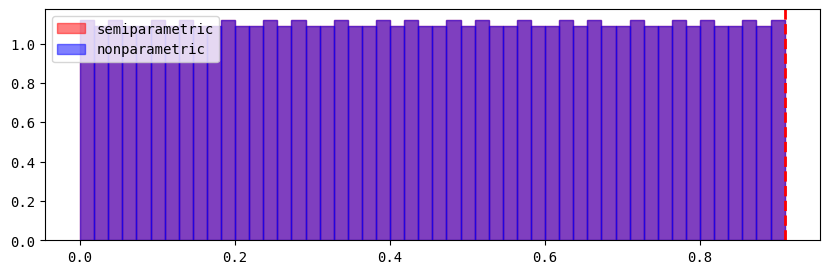

In [467]:
# plot below threshold
marginals0 = marginals[..., i, j, 0]
marginals1 = marginals_nonpara[..., i, j, 0]

assert np.allclose(marginals0[marginals0 <= f_thresh], marginals1[marginals1 <= f_thresh])

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(marginals0[marginals0 <= f_thresh].ravel(), color='red', edgecolor='red', alpha=.5,
        bins=50, density=True, label='semiparametric')
ax.hist(marginals1[marginals1 <= f_thresh].ravel(), color='blue', edgecolor='blue', alpha=.5,
        bins=50, density=True, label='nonparametric')
ax.axvline(x=f_thresh, color='red', linestyle='--', linewidth=2);
ax.legend(loc='upper left');

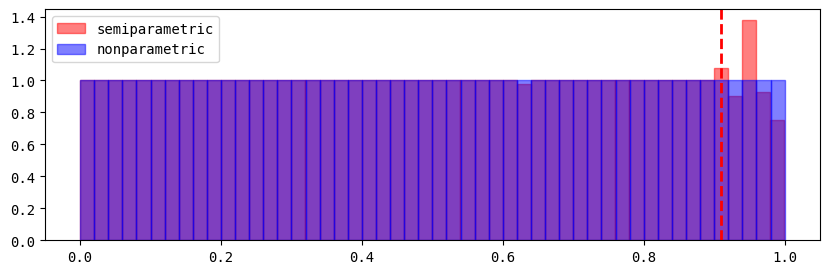

In [468]:
# plot all
marginals0 = marginals[..., i, j, 0]
marginals1 = marginals_nonpara[..., i, j, 0]

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(marginals0.ravel(), color='red', edgecolor='red', alpha=.5, bins=50, density=True,
        label='semiparametric')
ax.hist(marginals1.ravel(), color='blue', edgecolor='blue', alpha=.5, bins=50, density=True,
        label='nonparametric')
ax.axvline(x=f_thresh, color='red', linestyle='--', linewidth=2);
ax.legend(loc='upper left');

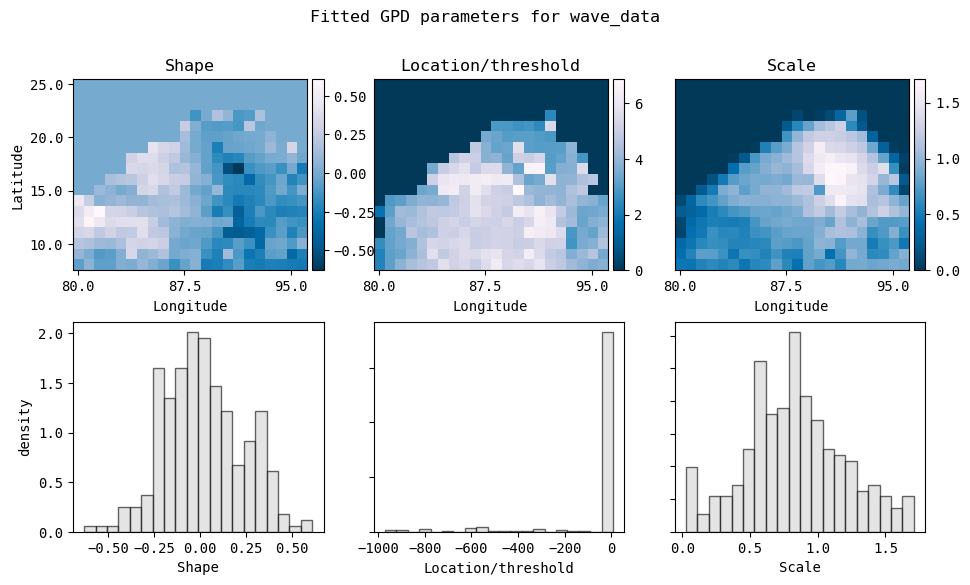

In [469]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def add_colorbar(fig, ax, im, side='right', size='5%', pad=0.05, orientation='vertical'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(side, size=size, pad=pad)
    fig.colorbar(im, cax=cax, orientation=orientation)
    
    
# Plot the distribution of the fitted parameters
fig, axs = plt.subplots(2, 3, figsize=(11, 6))

im0 = axs[0, 0].imshow(params[..., 0], cmap='PuBu_r')
im1 = axs[0, 1].imshow(params[..., 1], vmin=0, cmap='PuBu_r')
im2 = axs[0, 2].imshow(params[..., 2], cmap='PuBu_r');

add_colorbar(fig, axs[0, 0], im0)
add_colorbar(fig, axs[0, 1], im1)
add_colorbar(fig, axs[0, 2], im2);

axs[0, 0].set_title('Shape')
axs[0, 1].set_title('Location/threshold')
axs[0, 2].set_title('Scale');

for a in axs[0, :]:
    a.set_xticks([0, 10, 20])
    a.set_xticklabels(viz_utils.longitude)
    a.set_yticks([0, 5, 10, 15])
    a.set_yticklabels(viz_utils.latitude[::-1])
    a.set_xlabel('Longitude')
    a.set_ylabel('Latitude')
#     a.label_outer();

axs[0, 1].set_yticks([])
axs[0, 1].set_ylabel('')
axs[0, 2].set_yticks([])
axs[0, 2].set_ylabel('')

# second row                       
axs[1, 0].hist(params[x_valid, y_valid, 0].ravel(), bins=20, **hist_kwargs);
axs[1, 1].hist(params[x_valid, y_valid, 1].ravel(), bins=20, **hist_kwargs);
axs[1, 2].hist(params[x_valid, y_valid, 2].ravel(), bins=20, **hist_kwargs);

for a in axs[1, :]:
    a.set_ylabel('density')
    a.label_outer();

axs[1, 0].set_xlabel('Shape')
axs[1, 1].set_xlabel('Location/threshold')
axs[1, 2].set_xlabel('Scale');

fig.suptitle(f'Fitted GPD parameters for {variable}');
# fig.savefig(os.path.join(figdir, "general", f"params_{variable}.png"), dpi=300, bbox_inches='tight')

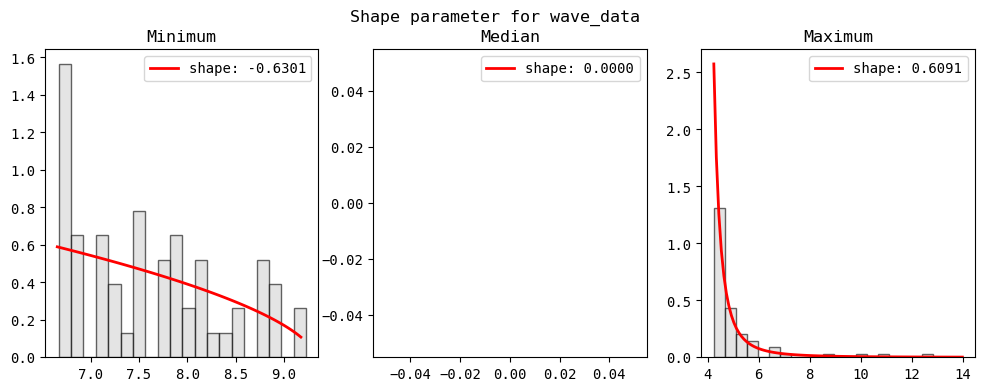

In [470]:
h, w, c = params.shape

shapes = [np.min(params[..., 0]), np.quantile(params[..., 0].ravel(), 0.5), np.max(params[..., 0])]
indices = [np.argmin(params[..., 0].ravel()), int((h * w) / 2), np.argmax(params[..., 0].ravel())]
indices = [translate_indices(ij) for ij in indices]
                 
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, c, index in zip(axs.ravel(), shapes, indices):
    
    y = train[:, index[0], index[1], 0]
    y = y[y > thresholds[index[0], index[1]]]
    ax.hist(y, bins=20, **hist_kwargs)
    
    rv = genpareto(*params[index[0], index[1]])
    
    x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
    ax.plot(x, rv.pdf(x), lw=2, label=f'shape: {c:.4f}', color='red')  
    ax.legend(loc='upper right');
    
axs[0].set_title('Minimum')
axs[1].set_title('Median')
axs[2].set_title('Maximum'); 

fig.suptitle(f'Shape parameter for {variable}');

fig.savefig(os.path.join(figdir, "general", f"fits_{variable}.png"), dpi=300, bbox_inches='tight')

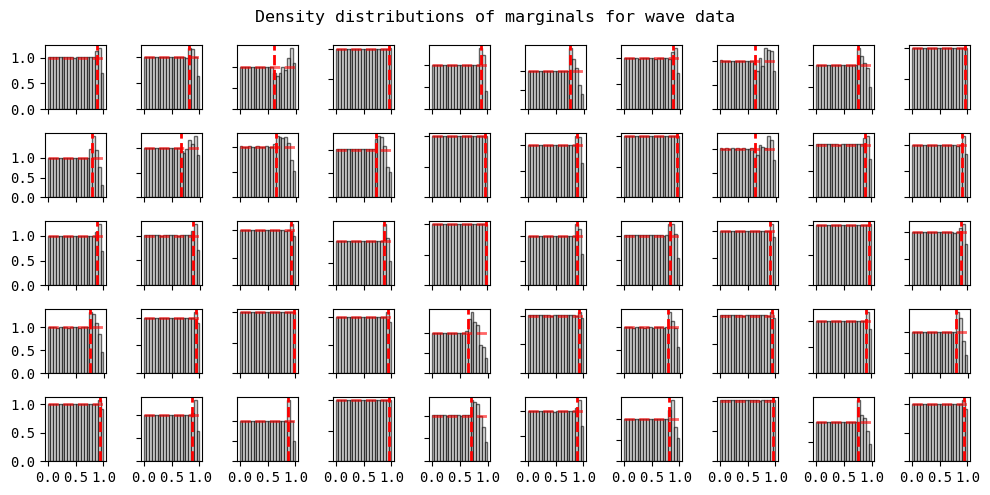

In [455]:
# histogram of marginals
from scipy.stats import uniform

fig, axs = plt.subplots(5, 10, figsize=(10, 5), layout='tight')

n, h, w, c = marginals.shape
indices = np.random.choice(indices_valid, size=50, replace=False)

# uniform for comparison
x = np.linspace(uniform.ppf(0.01), uniform.ppf(0.99), 50) 

for i, ax in zip(indices, axs.ravel()):
    _, bins, *_ = ax.hist(marginals.reshape(n, h * w, c)[..., i, 0].ravel(), alpha=0, bins=20, density=True)
    ax.hist(marginals.reshape(n, h * w, c)[..., i, 0].ravel(), bins=bins, **hist_kwargs)
    ax.plot(x, uniform.pdf(x), 'r--', lw=2, alpha=0.6)
    
    a, b = translate_indices(i)
    f_thresh_i = np.interp(thresholds[a, b], sorted(train[:, a, b, 0]), sorted(marginals[:, a, b, 0]))
    ax.axvline(x=f_thresh_i, color='r', linestyle='dashed', lw=2)
    
    ax.set_xticks([0, .5, 1])
    ax.set_yticks([0, .5, 1])
    ax.label_outer()

fig.suptitle(f"Density distributions of marginals for {variable.replace('_', ' ')}");

# Howard (2022) plots

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_59379/3513525708.py:23: RuntimeWarning: divide by zero encountered in log
  uniform_expected = -np.log(-np.log(uniform_expected))[1:]


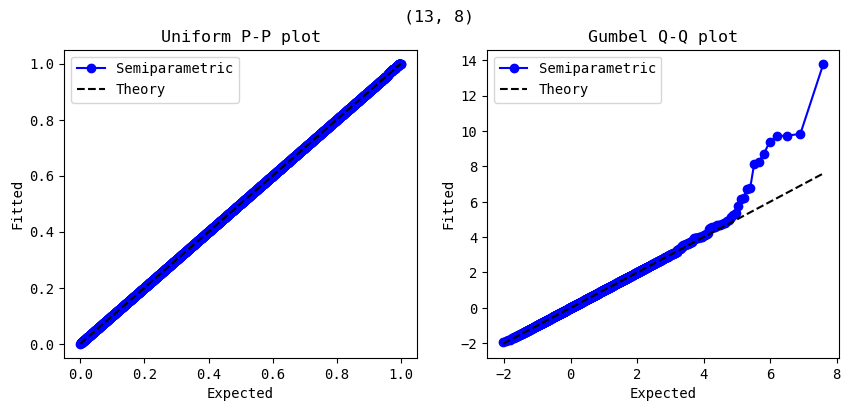

In [609]:
i, j = translate_indices(ij)
n = len(marginals[:, i, j, 0])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
ax = axs[0]
y =  sorted(marginals[:, i, j, 0])
uniform_expected = sorted(np.linspace(0., 1., n))

ax.plot(uniform_expected, y, '-o', color='blue', label='Semiparametric')
ax.plot(uniform_expected, uniform_expected, color='k', linestyle='dashed', label='Theory')
ax.set_xlabel('Expected')
ax.set_ylabel('Fitted')
ax.legend(loc='upper left')
ax.set_title('Uniform P-P plot')

# plot 2
ax = axs[1]

y =  sorted(marginals[:, i, j, 0])
y = -np.log(-np.log(y))[1:]
uniform_expected = sorted(np.linspace(0., 1., n))
uniform_expected = -np.log(-np.log(uniform_expected))[1:]

ax.plot(uniform_expected, y, '-o', color='blue', label='Semiparametric')
ax.plot(uniform_expected, uniform_expected, color='k', linestyle='dashed', label='Theory')
ax.set_xlabel('Expected')
ax.set_ylabel('Fitted')
ax.legend(loc='upper left')
ax.set_title('Gumbel Q-Q plot');

fig.suptitle(f'({i}, {j})');


/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_59379/2115443000.py:23: RuntimeWarning: divide by zero encountered in log
  x = -np.log(-np.log(x))
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_59379/2115443000.py:24: RuntimeWarning: divide by zero encountered in log
  y = -np.log(-np.log(y))


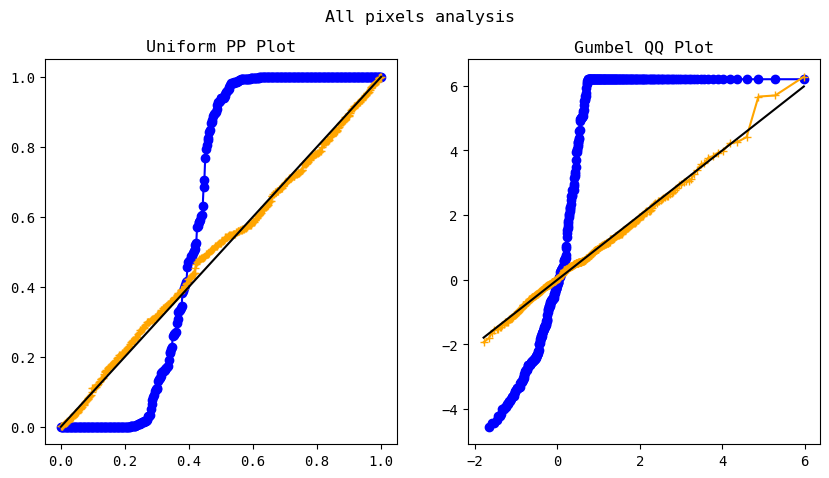

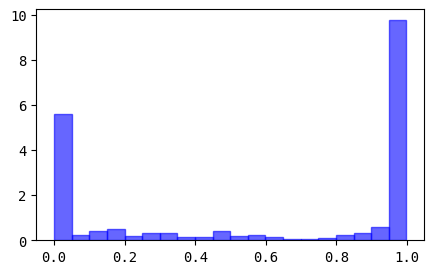

In [611]:
n, h, w, c = marginals.shape

uniform_sample = np.array([np.random.uniform(size=(n)) for i in range(h * w)])
uniform_maxima = np.max(uniform_sample, axis=1)
f_uniform = uniform_maxima ** n


maxima = np.max(marginals, axis=0).ravel()
f_maxima = np.power(maxima, n)

x = sorted(np.linspace(0., 1., h * w))
y = sorted(f_maxima)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.plot(x, y, '-o', color='blue', label='Semiparametric')
ax.plot(x, sorted(f_uniform), '-+', color='orange', label='Uniform')
ax.plot(x, x, color='k', label='Theory')
ax.set_title('Uniform PP Plot')

ax = axs[1]
x = -np.log(-np.log(x))
y = -np.log(-np.log(y))
f_uniform = -np.log(-np.log(f_uniform))

ax.plot(x, y, '-o', color='blue', label='Semiparametric')
ax.plot(x, sorted(f_uniform), '-+', color='orange', label='Uniform')
ax.plot(x, x, color='k', label='Theory')
ax.set_title('Gumbel QQ Plot');

# way overestimating the maxima overall

plt.figure(figsize=(5, 3))
plt.hist(f_maxima, bins=20, **hist_kwargs);

fig.suptitle('All pixels analysis');